In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
import sys
sys.path.insert(0, "../scripts_")
import warnings
from ml_flow import MlFlow
from data_cleaning import DataCleaning
from models import MlModels

In [2]:
#ignore warnings and assign object to class
warnings.filterwarnings('ignore')

In [3]:
#load data and import classes
df = pd.read_csv("../data/AdSmartABdata.csv")
DP = DataCleaning(df)
MP = MlFlow()
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [4]:
#drop users with no response
respond = DP.response(df)
#no. of rows and columns after dropping
respond.shape

(1243, 9)

* SPLIT DATA PER TWO PLATFORMS AND TOP THREE BROWSERS

In [5]:
platform1 = respond[respond['platform_os'] == 5]
clean_pl1 = platform1.drop('browser',axis=1)
platform2 = respond[respond['platform_os']==6]
clean_pl2 = platform2.drop('browser',axis=1)
#clean_pl1.to_csv("cleanpl1.csv")
#clean_pl2.to_csv("cleanpl2.csv")

In [6]:
brow = pd.DataFrame({'number of users':respond.groupby(['browser'])['auction_id'].count()}).reset_index()
brow = brow.sort_values(['number of users'],ascending=False)
print("\nTOP THREE BROWSERS USED BY CUSTOMERS\n")
brow.head(3)


TOP THREE BROWSERS USED BY CUSTOMERS



,browser,number of users
1,Chrome Mobile,695
2,Chrome Mobile WebView,227
4,Facebook,156


In [7]:
browser1 = respond[respond['browser']=="Chrome Mobile"]
browser2 = respond[respond['browser']=="Chrome Mobile WebView"]
browser3 = respond[respond['browser']=="Facebook"]

In [8]:
browser1.shape

(695, 9)

In [9]:
browser2.shape

(227, 9)

In [10]:
browser3.shape

(156, 9)

In [11]:
browser1.to_csv("browser1.csv")
browser2.to_csv("browser2.csv")
browser3.to_csv("browser3.csv")

* CLEAN DATA

In [12]:
file_path = ['../data/browser1.csv','../data/browser2.csv', '../data/browser3.csv', 'cleanpl1.csv', 'cleanpl2.csv']
def load_data(csv):
   data = pd.read_csv(csv)
   return data

#drop unnecessary columns for browser
def clean_browse(data):
    columns_to_be_dropped = ['no', 'Unnamed: 0', 'platform_os']
    br = data.drop(columns_to_be_dropped,axis=1)
    return br



#for browsers
chr = load_data(file_path[0])
chrome_mob = clean_browse(chr)
chr2 = load_data(file_path[1])
chrome_mob_wv = clean_browse(chr2)
fb = load_data(file_path[2])
fB = clean_browse(fb)

In [13]:
catagorical_columns, numerical_columns = MP.sep_cat_num(respond)
print("Numerical Columns:", catagorical_columns)
print("****************")
print("Categorical Columns:", numerical_columns)

Numerical Columns: ['auction_id', 'experiment', 'date', 'device_make', 'browser']
****************
Categorical Columns: ['hour', 'platform_os', 'yes', 'no']


* ML PROCESS FOR CHROME MOBILE

In [14]:
pipe_1 = Pipeline(
    steps=[
        ("label encoding", FunctionTransformer(MP.cat_labeler, kw_args={"cat_cols": catagorical_columns})),
        ("scaling", FunctionTransformer(MP.scaler)),
        ("separate target and features", FunctionTransformer(MP.target_feature, kw_args={"f_r": [0, 6], "t":-1})),
        ("divide dataset", FunctionTransformer(MP.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8})),      
        ])
sets = pipe_1.fit_transform(chrome_mob)

   auction_id  experiment  date  hour  device_make  browser  yes
0          41           0     6    12            1        0    1
1          23           1     5    20            1        0    1
2          22           1     5    20            1        0    1
3          21           1     7    15            1        0    1
4          19           0     0    15            1        0    1


scaled
   auction_id  experiment      date      hour  device_make  browser  yes
0    0.059078         0.0  0.857143  0.521739     0.076923      0.0  1.0
1    0.033141         1.0  0.714286  0.869565     0.076923      0.0  1.0
2    0.031700         1.0  0.714286  0.869565     0.076923      0.0  1.0
3    0.030259         1.0  1.000000  0.652174     0.076923      0.0  1.0
4    0.027378         0.0  0.000000  0.652174     0.076923      0.0  1.0


target_features output
features size: (695, 6)


splitted outputt
X_train shape: (512, 6)
y_train shape: (512,)
x_test shape: (70, 6)
y_test shape: (70,)
X_val s

accuracy:  0.4714285714285714
loss function:  binary:logistic


Text(0.5, 0, 'Xgboost Feature Importance')

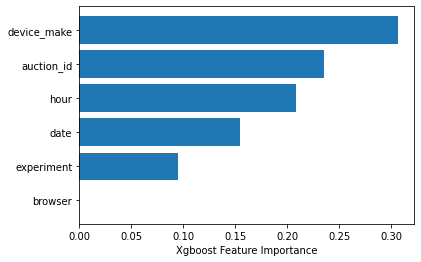

In [34]:
# generate model

MO = MlModels()
model = MO.xgb(sets[0], sets[1], sets[2], sets[3])


# Then predict results from X_test data
pred_xgb = model.predict(sets[2])


accuracy = accuracy_score(pred_xgb, sets[3])
print("accuracy: ", accuracy)

print("loss function: ", model.objective)

#feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
sorted_idx = model.feature_importances_.argsort()
columns = np.array(chrome_mob.columns.to_list()[:6])
plt.barh(columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

* ML PROCESS FOR CHROME MOBILE VIEWER

In [35]:
sets = pipe_1.fit_transform(chrome_mob_wv)

   auction_id  experiment  date  hour  device_make  browser  yes
0           4           1     1    11           57        0    1
1           5           1     2     2           10        0    1
2          10           1     5    21           32        0    1
3          12           1     1     0           31        0    1
4           9           0     0    15           29        0    1


scaled
   auction_id  experiment      date      hour  device_make  browser  yes
0    0.017699         1.0  0.142857  0.500000     0.730769      0.0  1.0
1    0.022124         1.0  0.285714  0.090909     0.128205      0.0  1.0
2    0.044248         1.0  0.714286  0.954545     0.410256      0.0  1.0
3    0.053097         1.0  0.142857  0.000000     0.397436      0.0  1.0
4    0.039823         0.0  0.000000  0.681818     0.371795      0.0  1.0


target_features output
features size: (227, 6)


splitted outputt
X_train shape: (167, 6)
y_train shape: (167,)
x_test shape: (23, 6)
y_test shape: (23,)
X_val s

accuracy:  0.6086956521739131
loss function:  binary:logistic


Text(0.5, 0, 'Xgboost Feature Importance')

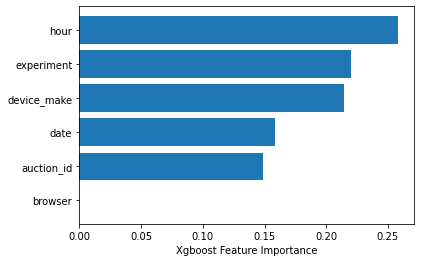

In [36]:
#generate model
model = MO.xgb(sets[0], sets[1], sets[2], sets[3])


# Then predict results from X_test data
pred_xgb = model.predict(sets[2])


accuracy = accuracy_score(pred_xgb, sets[3])
print("accuracy: ", accuracy)

print("loss function: ", model.objective)

#feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
sorted_idx = model.feature_importances_.argsort()
columns = np.array(chrome_mob_wv.columns.to_list()[:6])
plt.barh(columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")


* ML PROCESS FOR FACEBOOK

In [37]:
sets = pipe_1.fit_transform(fB)

   auction_id  experiment  date  hour  device_make  browser  yes
0           0           0     5     4           23        0    1
1           3           0     6    20           32        0    1
2           5           0     0    15            3        0    1
3           2           1     6    13           33        0    1
4          25           0     7    15            7        0    1


scaled
   auction_id  experiment      date      hour  device_make  browser  yes
0    0.000000         0.0  0.714286  0.173913     0.370968      0.0  1.0
1    0.019355         0.0  0.857143  0.869565     0.516129      0.0  1.0
2    0.032258         0.0  0.000000  0.652174     0.048387      0.0  1.0
3    0.012903         1.0  0.857143  0.565217     0.532258      0.0  1.0
4    0.161290         0.0  1.000000  0.652174     0.112903      0.0  1.0


target_features output
features size: (156, 6)


splitted outputt
X_train shape: (114, 6)
y_train shape: (114,)
x_test shape: (16, 6)
y_test shape: (16,)
X_val s

accuracy:  0.4375
loss function:  binary:logistic


Text(0.5, 0, 'Xgboost Feature Importance')

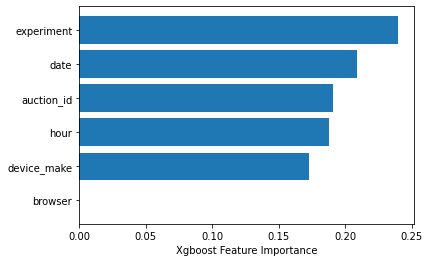

In [38]:
model = MO.xgb(sets[0], sets[1], sets[2], sets[3])


# Then predict results from X_test data
pred_xgb = model.predict(sets[2])


accuracy = accuracy_score(pred_xgb, sets[3])
print("accuracy: ", accuracy)

print("loss function: ", model.objective)

#feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
sorted_idx = model.feature_importances_.argsort()
columns = np.array(fB.columns.to_list()[:6])
plt.barh(columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

* LOGISTIC REGRESSION

In [39]:
pipe_2 =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])

In [40]:
pipe_2.fit(sets[0], sets[1])
pipe_2.score(sets[4],sets[5])

0.4230769230769231